In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from src.data_utils import *        
from src.models import UNet
from src.train_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"

time_start = "2018-01-01"
time_end = "2022-12-31"

zarr_ds = load_data(data_dir, time_start=time_start, time_end=time_end)

In [3]:
variables = [
    "CHL_cmes-level3",
    "CHL_cmes-gapfree",
    "air_temp",
    "sst",
    "curr_dir",
    "ug_curr",
    "u_wind",
    "v_wind",
    "v_curr",
]
stacked_data = stack_data(
    zarr_ds, variables=variables, normalize=False, drop_nans=False
)

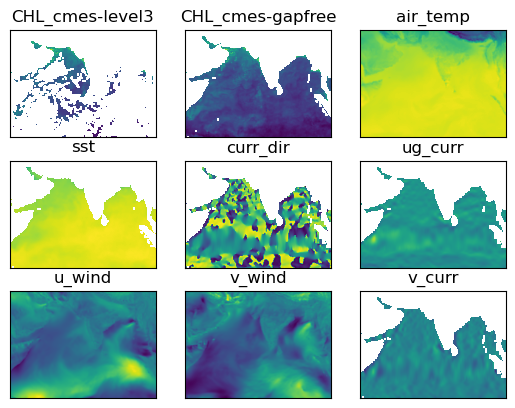

In [4]:
fig, axs = plt.subplots(3, 3)
t = 1
for i, ax in enumerate(axs.ravel()):
    ax.imshow(stacked_data[i][t, :, :])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(variables[i])

In [53]:
zarr_ds

<xarray.Dataset> Size: 7GB
Dimensions:                       (time: 1826, lat: 176, lon: 240)
Coordinates:
  * lat                           (lat) float32 704B 32.0 31.75 ... -11.5 -11.75
  * lon                           (lon) float32 960B 42.0 42.25 ... 101.5 101.8
  * time                          (time) datetime64[ns] 15kB 2018-01-01 ... 2...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 77MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 42kB dask.array<chunksize=(176, 240), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [5]:
train_loader, test_loader = get_data_loaders(zarr_ds, 0.8, batch_size=32)

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
torch.cuda.empty_cache()

In [39]:
model = UNet(in_channels=8, output_fun=F.relu).to(device)
model.compile()
opt = torch.optim.Adam(model.parameters(), lr=2e-4)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2, verbose=True)

In [40]:
n_epochs = 20
train_losses, test_losses = train(
    model,
    opt,
    criterion,
    train_loader,
    test_loader,
    device,
    num_epochs=n_epochs,
    scheduler=scheduler,
)

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.0075, Val Loss: 0.0065


Epoch 2/20, Train Loss: 0.0022, Val Loss: 0.0019


Epoch 3/20, Train Loss: 0.0018, Val Loss: 0.0017


Epoch 4/20, Train Loss: 0.0016, Val Loss: 0.0015


Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0013


Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0015


Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0011


Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010


Epoch 9/20, Train Loss: 0.0010, Val Loss: 0.0010


Epoch 10/20, Train Loss: 0.0010, Val Loss: 0.0010


Epoch 11/20, Train Loss: 0.0009, Val Loss: 0.0009


Epoch 12/20, Train Loss: 0.0008, Val Loss: 0.0009


Epoch 13/20, Train Loss: 0.0008, Val Loss: 0.0008


Epoch 14/20, Train Loss: 0.0008, Val Loss: 0.0007


Epoch 15/20, Train Loss: 0.0007, Val Loss: 0.0007


Epoch 16/20, Train Loss: 0.0007, Val Loss: 0.0007


Epoch 17/20, Train Loss: 0.0007, Val Loss: 0.0007


Epoch 18/20, Train Loss: 0.0007, Val Loss: 0.0007


Epoch 19/20, Train Loss: 0.0006, Val Loss: 0.0008


Epoch 20/20, Train Loss: 0.0006, Val Loss: 0.0006


In [13]:
def get_output(model, x):
    model.eval()
    with torch.no_grad():
        inputs = x.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()

    return outputs

In [1]:
x, y = next(iter(test_loader))
outputs = get_output(model, x)

NameError: name 'test_loader' is not defined

In [15]:
from src.plotting_utils import plot_output

In [90]:
i = 0

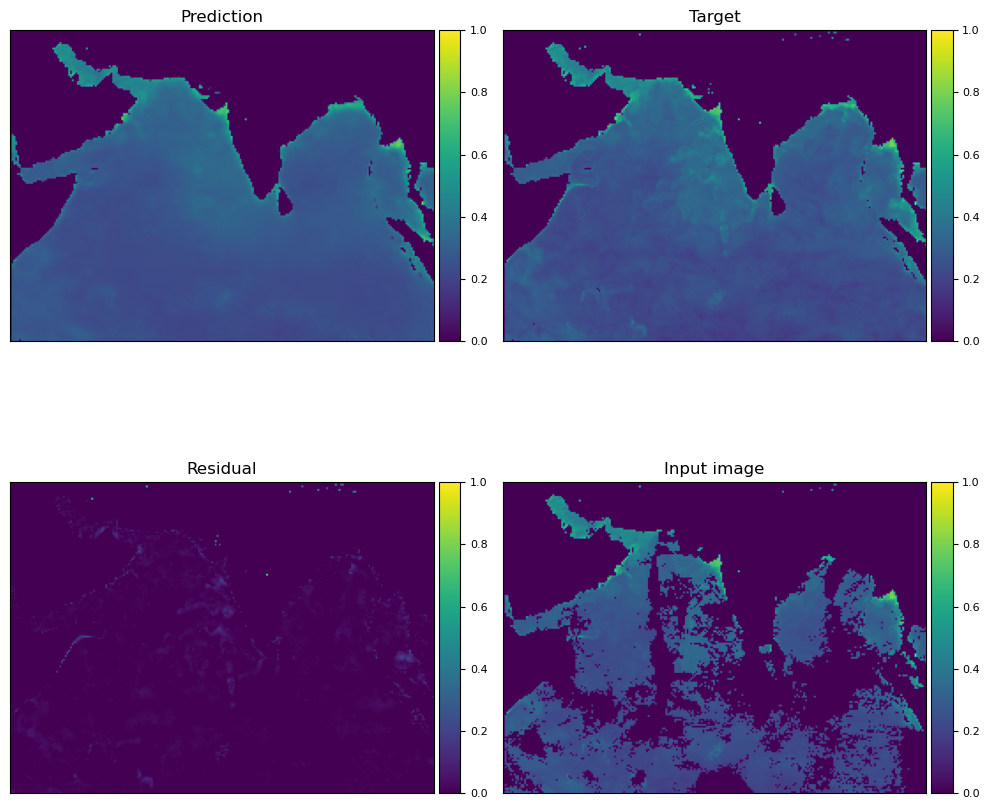

In [117]:
i += 1
plot_output(outputs, x, y, batch_ind=i, figsize=(10, 10))

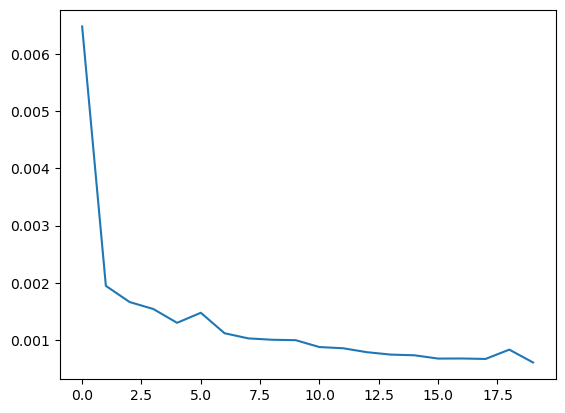

In [50]:
plt.plot(test_losses)

In [52]:
from ignite.metrics import SSIM
from ignite.engine import Engine


def eval_step(engine, batch):
    return batch


default_evaluator = Engine(eval_step)
metric = SSIM(data_range=1.0)
metric.attach(default_evaluator, "ssim")

x, y = next(iter(test_loader))
with torch.no_grad():
    output = model(x.to(device))
state = default_evaluator.run([[output, y.unsqueeze(1).to(device)]])
print(state.metrics["ssim"])

0.8823026925216161


In [82]:
torch.save(model.to("cpu"), "../saved_models/CHL_Unet_relu_v0.pt")

In [87]:
model = torch.load("../saved_models/CHL_Unet_relu_v0.pt", weights_only=False).to(device)

In [88]:
validate(model, criterion, test_loader, device)

0.0006138044142668756

In [97]:
import dask.array as da


def detect_anomalies(
    ds,
    variable="CHL_cmes-gapfree",
    window_size=5,
    std_threshold=3,
    temporal_window=7,
    temporal_threshold=0.5,
    min_chl=0,
    max_chl=20,
):
    """
    Detect anomalies in the chlorophyll data.

    :param ds: xarray Dataset containing the data
    :param variable: name of the chlorophyll variable to check
    :param window_size: size of the spatial window for local statistics
    :param std_threshold: number of standard deviations for spatial anomaly detection
    :param temporal_window: number of days to use for temporal consistency check
    :param temporal_threshold: maximum allowed change in log(CHL) for temporal check
    :param min_chl: minimum valid chlorophyll concentration
    :param max_chl: maximum valid chlorophyll concentration
    :return: boolean DataArray with True for detected anomalies
    """

    # Create a copy of the data to avoid modifying the original
    chl = ds[variable].copy()

    # Apply log transform to chlorophyll data
    log_chl = xr.apply_ufunc(np.log1p, chl, dask="allowed")

    # 1. Spatial anomaly detection
    def detect_spatial_anomalies(data):
        def rolling_stats(x):
            return xr.Dataset(
                {
                    "mean": x.rolling(
                        lat=window_size, lon=window_size, center=True
                    ).mean(),
                    "std": x.rolling(
                        lat=window_size, lon=window_size, center=True
                    ).std(),
                }
            )

        stats = data.pipe(rolling_stats)
        return xr.apply_ufunc(
            lambda x, m, s: np.abs(x - m) > std_threshold * s,
            data,
            stats["mean"],
            stats["std"],
            dask="allowed",
        )

    spatial_anomalies = detect_spatial_anomalies(log_chl)

    # 2. Temporal consistency check
    temporal_diff = log_chl.diff("time").rolling(time=temporal_window).mean()
    temporal_anomalies = (
        xr.apply_ufunc(np.abs, temporal_diff, dask="allowed") > temporal_threshold
    )

    # 3. Physical range check
    range_anomalies = (chl < min_chl) | (chl > max_chl)

    # Combine all anomaly checks
    all_anomalies = (
        spatial_anomalies | temporal_anomalies.fillna(False) | range_anomalies
    )

    return all_anomalies

In [100]:
zarr_ds

<xarray.Dataset> Size: 7GB
Dimensions:                       (time: 1826, lat: 176, lon: 240)
Coordinates:
  * lat                           (lat) float32 704B 32.0 31.75 ... -11.5 -11.75
  * lon                           (lon) float32 960B 42.0 42.25 ... 101.5 101.8
  * time                          (time) datetime64[ns] 15kB 2018-01-01 ... 2...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 77MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 42kB dask.array<chunksize=(176, 240), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 309MB dask.array<chunksize=(55, 176, 240), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0